In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from scipy import stats
import warnings
import xarray as xr
import xcorr
import os

In [2]:
plt.rcParams.update({'font.size': 9})

In [3]:
root = '../datasets'
save = False

## Load filtered time-lapse results
`freq_bw` and `status` are dropped to simplify the compute chain.

In [4]:
ds = xr.open_dataset(
    f"{root}/lfs/timelapse__IM.H03S[1-3]..EDH-IU.RAR.10.BH[RZ]__2014121__2020366__filtered.nc",
    drop_variables=['freq_bw', 'status']
)
ds.load()

<xarray.Dataset>
Dimensions:     (freq: 2, pair: 4, time1: 2493, time2: 2493)
Coordinates:
  * freq        (freq) float64 4.5 9.0
  * pair        (pair) object 'IM.H03S1..EDH-IU.RAR.10.BHR' ... 'IM.H03S3..ED...
  * time1       (time1) datetime64[ns] 2014-05-06T21:00:00 ... 2020-11-24T06:...
  * time2       (time2) datetime64[ns] 2014-05-06T21:00:00 ... 2020-11-24T06:...
Data variables:
    cc2         (pair, freq, time1, time2) float64 1.0 0.9891 0.9606 ... nan nan
    delta_freq  (pair, freq, time1, time2) float64 0.0 -0.0 -0.0 ... nan nan nan
    delta_lag   (pair, freq, time1, time2) float64 0.0 -0.0 -0.0 ... nan nan nan
Attributes: (12/14)
    sha256_hash_metadata:  e70c94ba62320fca480da48af721725b366e1584863945d734...
    sha256_hash:           4ae9bf16ac6b074a9d27f8843b0c38dfbcc31da3055c4db10e...
    title:                 Monowai Volcanic Centre: timelapse 2014.121-2020.3...
    institution:           Delft University of Technology, Department of Geos...
    author:                Pieter Smets - mail@pietersmets.be
    source:                CTBTO/IMS hydroacoustic data and IRIS/USGS seismic...
    ...                    ...
    history:               Filtered for eligible periods (signal-to-noise rat...
    doi:                    https://doi.org/10.5281/zenodo.5891059
    Conventions:           CF-1.9
    dependencies_version:  json-2.0.9, numpy-1.21.4, obspy-1.2.2, pandas-1.3....
    xcorr_version:         0.7.0
    format:                netCDF-4

In [5]:
def add_year_to_index(ax, time, minor=True, center=True):
    """
    """
    t0 = pd.to_datetime(time[0].values) + DateOffset(month=1, day=1, normalize=True)
    t1 = pd.to_datetime(time[-1].values) + DateOffset(years=1, month=1, day=1, normalize=True)
    
    int_index = xr.DataArray(np.arange(time.size), dims=('time',), coords=(time,))
    t_major = int_index.sel(time=pd.date_range(t0, t1, freq='12MS'), method="nearest")
    
    ax_t = ax.secondary_xaxis('top')
    ax_t.set_xticks(t_major.values[1:-1])
    ax_t.xaxis.set_major_formatter(ticker.NullFormatter())
    ax_t.set_xlabel(None)

    if minor:
        t_minor = int_index.sel(
            time=pd.date_range(t0 + DateOffset(month=7), t1 + DateOffset(years=-1, month=7), freq='12MS'),
            method="nearest"
        )
        if center:
            t_minor.values = t_major.values[:-1] + (t_major.diff('time', n=1)/2).astype(int).values
        
        ax_t.set_xticks(t_minor.values, minor=True)
        ax_t.set_xticklabels(t_minor.time.dt.strftime("%Y").values,
                             fontsize=6, fontstyle='italic', rotation=45, minor=True)
        
        for tick in ax_t.xaxis.get_minor_ticks():
            tick.tick1line.set_markersize(0)
            tick.tick2line.set_markersize(0)
            tick.label1.set_horizontalalignment('center')
            
    ax_r = ax.secondary_yaxis('right')
    ax_r.set_yticks(t_major.values[1:-1])
    ax_r.yaxis.set_major_formatter(ticker.NullFormatter())
    ax_r.set_ylabel(None)
            
    return (ax_t, ax_r)

### Filtered time-lapse plot with limited `delta_freq`

In [6]:
f = 0
freq = '6-12Hz' if f == 1 else '3-6Hz'

ds2 = ds.isel(freq=f).where((ds.delta_freq.isel(freq=f).signal.abs() <= .2), drop=True)

# print('selected {} out of {} times'.format(ds2.time1.size, ds.time1.size))

<IPython.core.display.Javascript object>


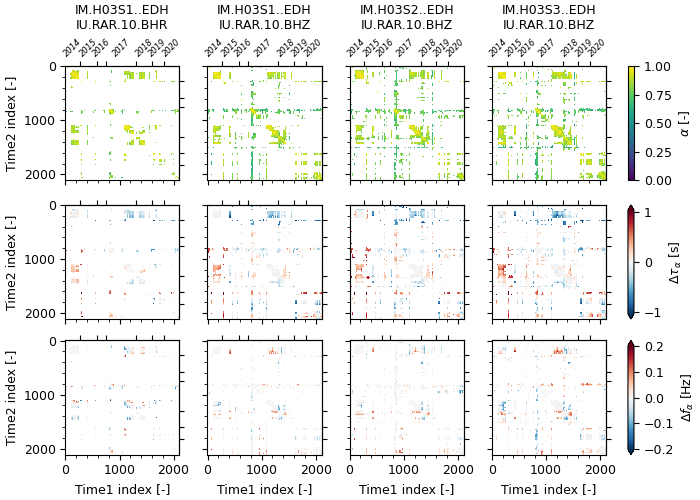

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(7, 5))

gs = GridSpec(
    figure=fig,
    nrows=3,
    ncols=5,
    height_ratios=(1, 1, 1,),
    width_ratios=(20, 20, 20, 20, 1)
)
gs.tight_layout(fig, pad=1.)

q = [.02, .98]

ax0 = []
for i in np.arange(0, 5):
    ax0.append(fig.add_subplot(gs[0, i]))

im0=[]
for p in np.arange(0, ds2.pair.size):
    im = ax0[p].imshow(X=ds2.cc2.isel(pair=p).values,
                       aspect=1, clim=[0, 1])
    im0.append(im)
    if p == 0:
        ax0[p].tick_params(labelbottom=False, labelleft=True)
        ax0[p].set_ylabel('Time2 index [-]')
    else:
        ax0[p].tick_params(labelbottom=False, labelleft=False)
    ax0[p].set_xlabel(None)
    ax0[p].xaxis.set_minor_locator(AutoMinorLocator())
    ax0[p].yaxis.set_minor_locator(AutoMinorLocator())
    ax0_t = add_year_to_index(ax0[p], ds2.time1, minor=True, center=True)
    ax0[p].set_title("\n".join(str(ds2.pair[p].values).split("-")), fontsize=9)

cb0 = plt.colorbar(im0[0], cax=ax0[-1], extend='neither')
cb0.ax.set_ylabel(r"$\alpha$" + f" [{ds2.cc2.units}]")


ax1 = []
for i in np.arange(0, 5):
    ax1.append(fig.add_subplot(gs[1, i]))

im1=[]
for p in np.arange(0, ds2.pair.size):
    im = ax1[p].imshow(X=ds2.delta_lag.isel(pair=p).values,
                       aspect=1, cmap='RdBu_r',
                       clim=np.array([-1, 1]) * np.abs(ds2.delta_lag.quantile(q)).max().values)
    im1.append(im)
    if p == 0:
        ax1[p].tick_params(labelbottom=False, labelleft=True)
        ax1[p].set_ylabel('Time2 index [-]')
    else:
        ax1[p].tick_params(labelbottom=False, labelleft=False)
    ax1[p].set_xlabel(None)
    ax1[p].xaxis.set_minor_locator(AutoMinorLocator())
    ax1[p].yaxis.set_minor_locator(AutoMinorLocator())
    ax1_t = add_year_to_index(ax1[p], ds2.time1, minor=False)

cb1 = plt.colorbar(im1[0], cax=ax1[-1], extend='both')
cb1.ax.set_ylabel(r"$\Delta \tau_{\alpha}$ [s]")


ax2 = []
for i in np.arange(0, 5):
    ax2.append(fig.add_subplot(gs[2, i]))

im2=[]
for p in np.arange(0, ds2.pair.size):
    im = ax2[p].imshow(X=ds2.delta_freq.isel(pair=p).values,
                       aspect=1, cmap='RdBu_r',
                       clim=np.array([-1, 1]) * np.abs(ds2.delta_freq.quantile(q)).max().values)
    im2.append(im)
    if p == 0:
        ax2[p].tick_params(labelbottom=True, labelleft=True)
        ax2[p].set_ylabel('Time2 index [-]')
    else:
        ax2[p].tick_params(labelbottom=True, labelleft=False)
    ax2[p].set_xlabel('Time1 index [-]')
    ax2[p].xaxis.set_minor_locator(AutoMinorLocator())
    ax2[p].yaxis.set_minor_locator(AutoMinorLocator())
    ax2_t = add_year_to_index(ax2[p], ds2.time1, minor=False)

cb2 = plt.colorbar(im2[0], cax=ax2[-1], extend='both')
cb2.ax.set_ylabel(r"$\Delta f_{\alpha}$ [Hz]")


plt.show()
if save:
    plt.savefig(f"figs/timelapse_{freq}_filtered_alpha_0.2Hz.pdf", dpi=300)

In [8]:
def rfunc(obj, trimmed=True, dim='time1', weight='w', weight_square=False, alpha=.05):
    """
    """
    # trim
    if trimmed:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            q = obj.quantile([.02, .98], dim=dim)
        m = True
        for v in list(obj.data_vars):
            m = m & (obj[v] >= q[v].isel(quantile=0)) & (obj[v] <= q[v].isel(quantile=-1))
        obj = obj.where(m, drop=True)
    if not obj:
        return
    
    # set weight
    w = np.square(obj[weight]) if weight_square else obj[weight]
    ws = w.sum(dim=dim, skipna=True)

    # count items in obj
    n = ((~w.isnull()) & (w >= 0)).sum(dim=dim)
    n0 = ((~w.isnull()) & (w > 0)).sum(dim=dim)
    
    # weighted sd parameter
    w_sd = (n0 - 1)*ws/n0
    
    # init new dataset
    ds = xr.Dataset()
    ds['n'] = n
    
    # Students T-test init
    t = xr.apply_ufunc(stats.t.ppf, 1-alpha/2, n-1)
    
    # map variables
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        for v in list(obj.data_vars):
            # set variable
            x = obj[v]
    
            # unweighted
            ds[v] = x.sum(dim=dim, skipna=True)/(n-1)
            x2 = np.square(ds[v])
            sd2 = (np.square(x-ds[v])).sum(dim=dim, skipna=True)/(n-1)
            ds[v+"_conf"] = t * np.sqrt((x2 + sd2) / n)
            
            # weighted
            vw = v+"_w"
            ds[vw] = (x*w).sum(dim=dim, skipna=True)/ws
            x2 = np.square(ds[vw])
            sd2 = (w*np.square(x-ds[vw])).sum(dim=dim, skipna=True)/w_sd
            ds[vw+"_conf"] = t * np.sqrt((x2 + sd2) / n)
            

    ds.attrs['weight'] = weight
    ds.attrs['weight_squared'] = weight_square
    ds.attrs['trimmed'] = trimmed
    ds.attrs['alpha'] = alpha
                                    
    return ds


def errplot(ax, ds, var="delta_lag", label=True, **kwargs):
    """
    """
    x, y, yerr = ds.time.values, ds[var].values, ds[var+"_conf"].values
    ax.errorbar(x, y, yerr=yerr, fmt="o", label=str(ds.pair.values) if label else None, **kwargs)

### Add weight based on delta_freq and CC2

delta_freq -> assumed normal distributed with $location = 0$ and $scale=.1$

In [9]:
def delta_freq_weight(df, loc=0., scale=.1):
    """Construct the normalized Gaussian weight given loc and scale.
    """
    return stats.norm.pdf(df, loc=loc, scale=scale)/stats.norm.pdf(loc, loc=loc, scale=scale)

In [10]:
ds['w'] = delta_freq_weight(ds.delta_freq, loc=0., scale=.1) * ds.cc2
suffix = ""

## Lag variation over time

In [11]:
d = ds.groupby(ds.time2).map(rfunc, trimmed=True).rename({'time2': 'time'})
d['delta_lag'] = d.delta_lag - d.delta_lag.mean(dim='time')  # detrend
d

<xarray.Dataset>
Dimensions:            (freq: 2, pair: 4, time: 2493)
Coordinates:
  * freq               (freq) float64 4.5 9.0
  * pair               (pair) object 'IM.H03S1..EDH-IU.RAR.10.BHR' ... 'IM.H0...
  * time               (time) datetime64[ns] 2014-05-06T21:00:00 ... 2020-11-...
Data variables: (12/17)
    n                  (time, pair, freq) float64 1.932e+03 1.907e+03 ... nan
    cc2                (time, pair, freq) float64 0.6704 0.6305 ... 0.7203 nan
    cc2_conf           (time, pair, freq) float64 0.03008 0.02844 ... nan
    cc2_w              (time, pair, freq) float64 0.714 0.6657 ... 0.7304 nan
    cc2_w_conf         (time, pair, freq) float64 0.03198 0.03 ... 0.03258 nan
    delta_freq         (time, pair, freq) float64 0.2571 0.4441 ... -0.07705 nan
    ...                 ...
    delta_lag_w        (time, pair, freq) float64 0.6785 0.7066 ... 0.1948 nan
    delta_lag_w_conf   (time, pair, freq) float64 0.03246 0.03436 ... nan
    w                  (time, pair, freq) float64 0.3812 0.3018 ... 0.4996 nan
    w_conf             (time, pair, freq) float64 0.02252 0.01922 ... nan
    w_w                (time, pair, freq) float64 0.668 0.6067 ... 0.5808 nan
    w_w_conf           (time, pair, freq) float64 0.03043 0.02788 ... nan
Attributes:
    weight:          w
    weight_squared:  False
    trimmed:         True
    alpha:           0.05

In [12]:
save = True

<IPython.core.display.Javascript object>


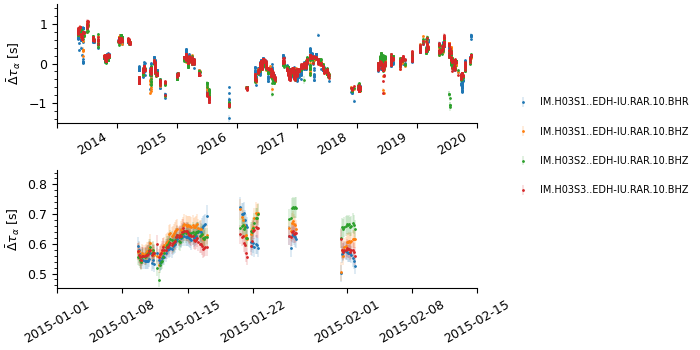

In [13]:
fig = plt.figure(constrained_layout=True, figsize=(7, 3.5))
gs = GridSpec(2, 2, figure=fig, height_ratios=(1, 1), width_ratios=(2.5, 1))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

t0, t1 = np.datetime64('2015-01-01'), np.datetime64('2015-02-15')
t = d.time.where((d.time >= t0) & (d.time <= t1), drop=True)

var = "delta_lag_w"

for i in range(d.pair.size):
    errplot(ax1, d.isel(freq=0, pair=i), var=var, ms=1, elinewidth=.2)
    errplot(ax2, d.isel(freq=0, pair=i), var=var, ms=1, elinewidth=.2)
    
legend = ax1.get_legend_handles_labels()

# format ax1
ax1.set_ylabel(r"${\bar{\Delta} \tau_{\alpha}}$ [s]")
ax1.set_ylim(-1.5, 1.5)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xlabel(None)
xcorr.plot.set_year_labels(ax1, rotation=30)
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# format ax2
ax2.set_ylabel(r"${\bar{\Delta} \tau_{\alpha}}$ [s]")
ax2.set_ylim(.45, .85)
ax2.set_xlim(t0, t1)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.tick_params(axis='x', rotation=30)
ax2.yaxis.set_minor_locator(AutoMinorLocator())

# format ax3
ax3.set_frame_on(False)
ax3.tick_params(bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax3.legend(*legend, fontsize=7, loc='center left', frameon=False, labelspacing=2, borderpad=-2)

if save:
    plt.savefig(f"figs/H03S_timelapse_{var}_3-6Hz{suffix}.pdf", bbox_inches='tight')

<IPython.core.display.Javascript object>


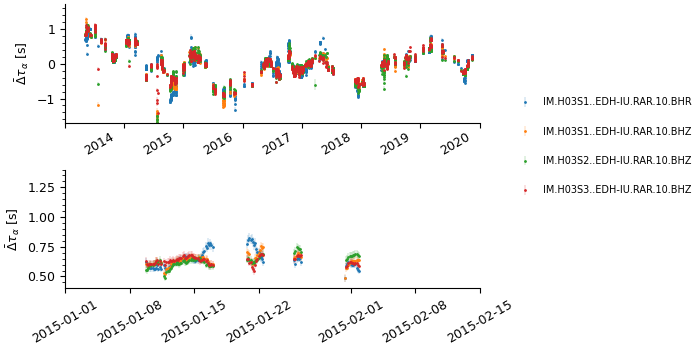

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(7, 3.5))
gs = GridSpec(2, 2, figure=fig, height_ratios=(1, 1), width_ratios=(2.5, 1))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

t0, t1 = np.datetime64('2015-01-01'), np.datetime64('2015-02-15')
t = d.time.where((d.time >= t0) & (d.time <= t1), drop=True)

var = "delta_lag_w"

for i in range(d.pair.size):
    errplot(ax1, d.isel(freq=1, pair=i), var=var, ms=1, elinewidth=.2)
    errplot(ax2, d.isel(freq=1, pair=i), var=var, ms=1, elinewidth=.2)
    
legend = ax1.get_legend_handles_labels()

# format ax1
ax1.set_ylabel(r"${\bar{\Delta} \tau_{\alpha}}$ [s]")
# ax1.set_ylim(-1.25, 1.25)
ax1.set_ylim(-1.7, 1.7)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xlabel(None)
xcorr.plot.set_year_labels(ax1, rotation=30)
ax1.yaxis.set_minor_locator(AutoMinorLocator())

# format ax2
ax2.set_ylabel(r"${\bar{\Delta} \tau_{\alpha}}$ [s]")
# ax2.set_ylim(.45, 0.85)
ax2.set_ylim(.4, 1.4)
ax2.set_xlim(t0, t1)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.tick_params(axis='x', rotation=30)
ax2.yaxis.set_minor_locator(AutoMinorLocator())

# format ax3
ax3.set_frame_on(False)
ax3.tick_params(bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax3.legend(*legend, fontsize=7, loc='center left', frameon=False, labelspacing=2, borderpad=-2)

if save:
    plt.savefig(f"figs/H03S_timelapse_{var}_6-12Hz{suffix}.pdf", bbox_inches='tight')

## Robust linear model estimation

In [15]:
from sklearn import linear_model, model_selection, ensemble, metrics
from scipy import stats
from scipy.interpolate import interp1d

In [16]:
def to_epoch(time, base='2000-01-01'):
    """Returns epoch (in seconds) from base
    """
    time = pd.to_datetime(time).to_datetime64() if isinstance(time, str) else time
    return (time - pd.to_datetime(base).to_datetime64()) / pd.to_timedelta('1s')
    
    
def to_datetime(epoch, base='2000-01-01'):
    """Returns datetime from epoch seconds wrt base
    """
    return pd.to_datetime(base).to_datetime64() + pd.to_timedelta(epoch, unit='s')

def eval_ensemble_linear_regression(ds: xr.Dataset, var: str = 'delta_lag', weighted: bool = True, **kwargs):
    """
    """
    # filter
    ds = ds[[var, var+"_conf"]].dropna(dim='time')
    
    # to numpy arrays
    X = ds['time'].values[:, np.newaxis]
    y = ds[var].values
    w = (1/ds[var + "_conf"]).values if weighted else None
    
    return ensemble_linear_regression(X, y, w, **kwargs)
    

def ensemble_linear_regression(X, y, w=None,
                               alpha_ci: float = 0.05,
                               alpha_pi: float = None,
                               b_samples: int = 5,
                               ax = None,
                               plot: bool = True,
                               plot_kwargs = dict(),
                               plot_bootstrap: bool = False,
                               plot_bootstrap_kwargs = dict(color='gray', alpha=.5),
                               add_legend: bool = True,
                               legend_kwargs = None,
                               **kwargs):
    """
    """
    # defined axes?
    if plot:
        ax = ax or plt.gca()

    # get number of samples
    n_samples = len(y)
    
    # datetime
    x_dt = X.dtype == np.dtype('datetime64[ns]')
    X = to_epoch(X.squeeze())[:, np.newaxis] if x_dt else X

    # create the regression ensemble and fit
    model = ensemble.BaggingRegressor(linear_model.LinearRegression(), **kwargs)
    model.fit(X, y, w)

    # set equally sampled points for bootstrap evaluation
    b_index = np.linspace(0, n_samples-1, b_samples, dtype=np.int64)
    X_b = X[b_index]
    y_b = np.zeros((model.n_estimators, b_samples), dtype=np.float64)

    # process bootstrap results
    for i, m in enumerate(model.estimators_):

        # bootstrap model prediction for X_b
        y_b[i, :] = m.predict(X_b)
    
        # add to plot?
        if plot_bootstrap:
            ax.plot(X_b, y_b[i, :], **plot_bootstrap_kwargs)

    # epoch back to datetime64
    X_b_ = to_datetime(X_b.squeeze()) if x_dt else X_b

    # model prediction (ensemble average)
    yhat_b = np.mean(y_b, axis=0)
    if plot:
        line, = ax.plot(X_b_, yhat_b, 'k-',
                        label='OLS' if w is None else 'WLS',
                        **plot_kwargs)

    # Variance of the bootstrap model prediction
    var_y_b = np.sum(np.square(y_b - yhat_b), axis=0)/(model.n_estimators-1)

    # Variance of the forecast error
    var_e = np.sum(np.square(y - model.predict(X)))/(n_samples-1)

    # confidence interval (percentile interval)
    y_b_ci_min = np.percentile(y_b, 100*alpha_ci/2, axis=0)
    y_b_ci_max = np.percentile(y_b, 100*(1-alpha_ci/2), axis=0)

    if plot:
        line, = ax.plot(X_b_, y_b_ci_min, color='.5', linestyle='dashed',
                        label=f"{100*(1-alpha_ci):.0f}% CI",
                        **plot_kwargs)
        ax.plot(X_b_, y_b_ci_max, color='.5', linestyle='dashed', **plot_kwargs)

    # prediction interval (Student's t-value for n-2 degrees of freedom)
    alpha_pi = alpha_pi or alpha_ci
    t = stats.t.ppf(1-alpha_pi/2, n_samples-2)
    y_b_pi = t * np.sqrt(var_y_b + var_e)
    y_b_pi_min = yhat_b - y_b_pi
    y_b_pi_max = yhat_b + y_b_pi

    if plot:
        line, = ax.plot(X_b_, y_b_pi_min, color='k', linestyle='dotted',
                        label=f"{100*(1-alpha_ci):.0f}% PI",
                        **plot_kwargs)
        ax.plot(X_b_, y_b_pi_max, color='k', linestyle='dotted', **plot_kwargs)
        
    # add to model
    model.n_samples = n_samples
    model.alpha_ci = alpha_ci
    model.alpha_pi = alpha_pi
    model._X_b = X_b
    model._yhat_b = yhat_b
    model._X_b_conf_interval = np.array([y_b_ci_min - yhat_b, y_b_ci_max - yhat_b])
    model._X_b_pred_interval = y_b_pi

    model.conf_interval = interp1d(X_b.ravel(), model._X_b_conf_interval)
    model.pred_interval = interp1d(X_b.ravel(), model._X_b_pred_interval)

    if add_legend:
        legend_kwargs = {
            'bbox_to_anchor': (1.2, 0),
            'loc': 'lower left',
            'title': "Linear\nRegression",
            'title_fontsize': 8,
            'fontsize': 7,
            'frameon': False,
            'labelspacing': 1,
            'borderpad': 0,
            **(legend_kwargs or dict())
        }
        ax.legend(**legend_kwargs)

    return model

Combine with triplet average (vertical channel only)

In [17]:
dc = xr.concat([d, (d.sel(pair=d.pair[1:])
                     .median(dim='pair', skipna=True)
                     .assign_coords(pair=str(d.pair[-1].values).replace('H03S3', 'H03S?')))
               ], dim='pair')

<IPython.core.display.Javascript object>


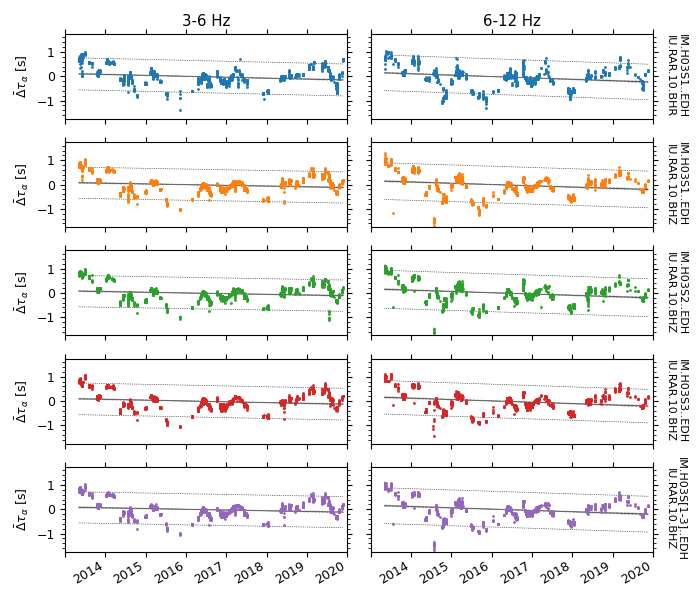

In [18]:
fig = plt.figure(constrained_layout=False, figsize=(7, 6))

g = GridSpec(dc.pair.size, dc.freq.size, figure=fig)

var = "delta_lag_w"
ax = []

for i, c in zip(range(dc.pair.size),  mpl.rcParams['axes.prop_cycle']()):
    
    # set axes
    ax0 = fig.add_subplot(g[i, 0])
    ax1 = fig.add_subplot(g[i, 1])
    
    errplot(ax0, dc.isel(freq=0, pair=i), var=var, label=False, ms=1, elinewidth=.2, **c)

    ax0.set_ylim(-1.75, 1.75)
    ax0.set_xlabel(None)
    xcorr.plot.set_year_labels(ax0, rotation=30)
    ax0.set_ylabel(r"${\bar{\Delta} \tau_{\alpha}}$ [s]")
    ax0.yaxis.set_minor_locator(AutoMinorLocator())
    ax0.xaxis.set_ticks_position('both')
    ax0.yaxis.set_ticks_position('both')
    
    errplot(ax1, dc.isel(freq=1, pair=i), var=var, label=False, ms=1, elinewidth=.2, **c)
    
    ax1.set_ylim(-1.75, 1.75)
    ax1.set_xlabel(None)
    ax1.set_ylabel(None)
    xcorr.plot.set_year_labels(ax1, rotation=30)
    ax1.set_yticklabels([])
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax1.xaxis.set_ticks_position('both')
    ax1.yaxis.set_ticks_position('both')
    
    ax1.yaxis.set_label_position("right")
    ax1.set_ylabel(str(dc.pair[i].values).replace('-', "\n").replace('?', '[1-3]'),
                   rotation=-90, labelpad=24, fontsize=8)
    
    if i == 0:
        ax0.set_title("3-6 Hz")
        ax1.set_title("6-12 Hz")
    if i != dc.pair.size-1:
        ax0.set_xticklabels([], minor=True)
        ax1.set_xticklabels([], minor=True)

    ax.append([ax0, ax1])

g.axes = np.array(ax)

plt.tight_layout()

if save:
    g.figure.savefig(f"figs/H03S_timelapse_time_delta_lag{suffix}.pdf", bbox_inches='tight')

In [19]:
regr_args = dict(n_estimators=20000, max_samples=1., bootstrap=True, n_jobs=2, alpha_ci=.05,
                 plot_kwargs=dict(linewidth=.5))
factor = 1000  # to milliseconds

for ix, iy in np.ndindex(g.axes.shape):
    add_legend = (ix+1, iy+1) == g.axes.shape
    model = eval_ensemble_linear_regression(dc.isel(pair=ix, freq=iy), weighted=True, var=var,
                                            ax=g.axes[ix, iy], add_legend=add_legend,
                                            **regr_args)
    print("{pair} {freq} {trend:.1f} +/-{ci:.1f}ms ({pi:.1f}s)".format(
        pair=str(dc.pair[ix].values).replace("\n", "-"),
        freq="3-6Hz" if dc.freq[iy].values == 4.5 else "6-12Hz",
        trend=(model.predict([[to_epoch('2017-01-01')]]).item() -
               model.predict([[to_epoch('2016-01-01')]]).item()
              )*factor,
        ci=np.mean(np.abs(
            model.conf_interval(to_epoch('2017-01-01')) -
            model.conf_interval(to_epoch('2016-01-01'))
        ))*factor,
        pi=model.pred_interval(to_epoch('2017-01-01')),
    ))

if save:
    g.figure.savefig(f"figs/H03S_timelapse_time_delta_lag_trends{suffix}.pdf", bbox_inches='tight')

IM.H03S1..EDH-IU.RAR.10.BHR 3-6Hz -38.5 +/-2.4ms (0.7s)
IM.H03S1..EDH-IU.RAR.10.BHR 6-12Hz -57.7 +/-2.6ms (0.7s)
IM.H03S1..EDH-IU.RAR.10.BHZ 3-6Hz -29.7 +/-3.3ms (0.6s)
IM.H03S1..EDH-IU.RAR.10.BHZ 6-12Hz -52.5 +/-3.6ms (0.8s)
IM.H03S2..EDH-IU.RAR.10.BHZ 3-6Hz -28.6 +/-3.3ms (0.6s)
IM.H03S2..EDH-IU.RAR.10.BHZ 6-12Hz -53.1 +/-3.3ms (0.8s)
IM.H03S3..EDH-IU.RAR.10.BHZ 3-6Hz -33.6 +/-3.3ms (0.7s)
IM.H03S3..EDH-IU.RAR.10.BHZ 6-12Hz -55.6 +/-3.6ms (0.7s)
IM.H03S?..EDH-IU.RAR.10.BHZ 3-6Hz -30.0 +/-3.3ms (0.6s)
IM.H03S?..EDH-IU.RAR.10.BHZ 6-12Hz -53.5 +/-3.6ms (0.7s)


## Periodogram

In [20]:
time = (d.time - d.time[0]) / pd.Timedelta('1D')
time.attrs = dict(units='days', long_name='Relative time from first sample')

delta_lag = dc.delta_lag_w.assign_coords(time=time)
delta_lag['pair'] = delta_lag.pair.str.replace('?', '[1-3]')

In [21]:
f = xr.DataArray(
    data=np.logspace(np.log10(1), np.log10(3.5*365.25), 500),
    dims=('period',),
    name='period',
    attrs={'units': 'days', 'long_name':'Period', 'standard_name': 'period',}
)

pgram = xcorr.signal.lombscargle(
    delta_lag.signal.detrend(dim='time', type='linear'), f,
    dim='time', precenter=True, rescale=True, invert=True, 
)

<IPython.core.display.Javascript object>


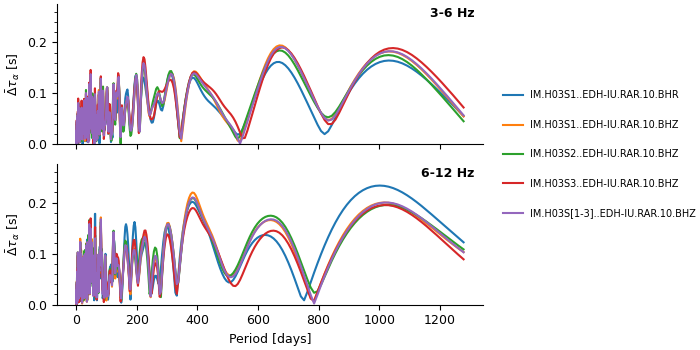

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(7, 3.5))
gs = GridSpec(2, 2, figure=fig, height_ratios=(1, 1), width_ratios=(2.5, 1))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

for pair in pgram.pair:
    pgram.sel(freq=pgram.freq[0], pair=pair).plot.line(x='period', ax=ax1, add_legend=False, label=str(pair.values))
    pgram.sel(freq=pgram.freq[1], pair=pair).plot.line(x='period', ax=ax2, add_legend=False)
    
legend = ax1.get_legend_handles_labels()

# format ax1
ax1.set_title(None)
ax1.tick_params(labelbottom=False)
ax1.set_ylabel(r"${\bar{\Delta} \tau_{\alpha}}$ [s]")
ax1.set_ylim(0, .275)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xlabel(None)
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.text(.98, .98, "3-6 Hz", ha='right', va='top', transform=ax1.transAxes, fontweight='bold',
         bbox=dict(facecolor='w', edgecolor='none', pad=0),
        )

# format ax2
ax2.set_title(None)
ax2.set_ylabel(r"${\bar{\Delta} \tau_{\alpha}}$ [s]")
ax2.set_ylim(.0, .275)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.text(.98, .98, "6-12 Hz", ha='right', va='top', transform=ax2.transAxes, fontweight='bold',
         bbox=dict(facecolor='w', edgecolor='none', pad=0),
        )

# format ax3
ax3.set_frame_on(False)
ax3.tick_params(bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax3.legend(*legend, fontsize=7, loc='center left', frameon=False, labelspacing=2, borderpad=0)

if save:
    plt.savefig(f"figs/H03S_timelapse_time_delta_lag_lombscargle{suffix}.pdf", bbox_inches='tight')

<IPython.core.display.Javascript object>


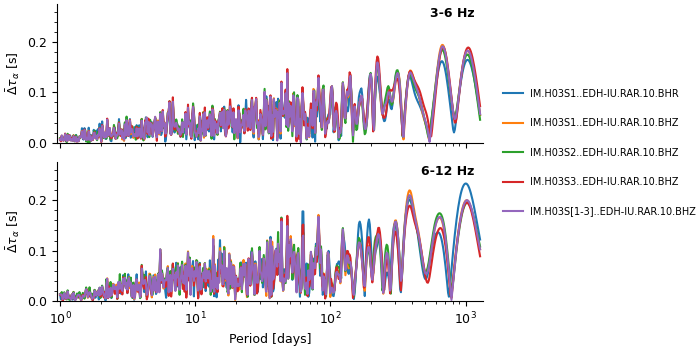

In [23]:
fig = plt.figure(constrained_layout=True, figsize=(7, 3.5))
gs = GridSpec(2, 2, figure=fig, height_ratios=(1, 1), width_ratios=(2.5, 1))

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

for pair in pgram.pair:
    pgram.sel(freq=pgram.freq[0], pair=pair).plot.line(x='period', xscale='log', ax=ax1, add_legend=False, label=str(pair.values))
    pgram.sel(freq=pgram.freq[1], pair=pair).plot.line(x='period', xscale='log', ax=ax2, add_legend=False)
    
legend = ax1.get_legend_handles_labels()

# format ax1
ax1.set_title(None)
ax1.tick_params(labelbottom=False)
ax1.set_xlim(.95, 3.5*365.25*1.05)
ax1.set_ylabel(r"${\bar{\Delta} \tau_{\alpha}}$ [s]")
ax1.set_ylim(0, .275)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xlabel(None)
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.text(.98, .98, "3-6 Hz", ha='right', va='top', transform=ax1.transAxes, fontweight='bold',
         bbox=dict(facecolor='w', edgecolor='none', pad=0),
        )

# format ax2
ax2.set_title(None)
ax2.set_xlim(.95, 3.5*365.25*1.05)
ax2.set_ylabel(r"${\bar{\Delta} \tau_{\alpha}}$ [s]")
ax2.set_ylim(.0, .275)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.text(.98, .98, "6-12 Hz", ha='right', va='top', transform=ax2.transAxes, fontweight='bold',
         bbox=dict(facecolor='w', edgecolor='none', pad=0),
        )

# format ax3
ax3.set_frame_on(False)
ax3.tick_params(bottom=False, top=False, left=False, right=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax3.legend(*legend, fontsize=7, loc='center left', frameon=False, labelspacing=2, borderpad=0)

if save:
    plt.savefig(f"figs/H03S_timelapse_time_delta_lag_lombscargle_log{suffix}.pdf", bbox_inches='tight')